# Instanciate Azure OpenAI Client

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the variables
api_key = os.getenv('AZURE_OPENAI_API_KEY')
endpoint = os.getenv('AZURE_OPENAI_ENDPOINT')
deployment = os.getenv('MODEL_DEPLOYMENT')

#print(f"API Key: {api_key}")
#print(f"Endpoint: {endpoint}")
#print(f"Deployment: {deployment}")

In [2]:
from openai import AzureOpenAI, ChatCompletion
import json
import os

api_key = api_key
endpoint = endpoint
deployment = deployment

# Initialize the AzureOpenAI client
client = AzureOpenAI(
    api_key=api_key,
    azure_endpoint=endpoint,
    #azure_deployment=deployment,
    api_version="2024-10-01-preview"
)

# Load Dataset

In [3]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
def create_dataset(use_full_train=False):
    """
    DocVQA dataset from the Hugging Face Hub
    """
    train_dataset = load_dataset('HuggingFaceM4/ChartQA', split='train')
    train_dataset = train_dataset.remove_columns(['human_or_machine'])

    eval_dataset = load_dataset('HuggingFaceM4/ChartQA', split='val')
    eval_dataset = eval_dataset.remove_columns(['human_or_machine'])

    test_dataset = load_dataset('HuggingFaceM4/ChartQA', split='test')
    test_dataset = test_dataset.remove_columns(['human_or_machine'])

    return train_dataset, eval_dataset, test_dataset

In [4]:
ds_train,ds_val, ds_test=create_dataset()

In [5]:
import pandas as pd
from io import BytesIO
from PIL import Image

# sample 150 training examples, 50 validation examples and 100 test examples
ds_train_df_small = ds_train.shuffle(seed=42).select(range(100))
ds_val_df_small = ds_val.shuffle(seed=42).select(range(50))
ds_test_df_small = ds_test.shuffle(seed=42).select(range(100))


In [6]:
# convert to pandas dataframe
ds_train_df = ds_train_df_small.to_pandas()
ds_val_df = ds_val_df_small.to_pandas()
ds_test_df = ds_test_df_small.to_pandas()


In [7]:
ds_train_df.columns

Index(['image', 'query', 'label'], dtype='object')

In [8]:
from IPython.display import display

# Display the ds_train DataFrame
display(ds_train_df)

,image,query,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What is the sales performance of accessories b...,[36]
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Is the cardiovascular disease more then sum of...,[Yes]
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was the youth unemployment rate in Bosnia...,[33.97]
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was MWG's net revenue in 2019?,[102.17]
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was the infant mortality rate in Uzbekist...,[15.6]
...,...,...,...
95,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Is the average of all the values in 2007 great...,[No]
96,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What year is the forecasted budget balance for...,[2020]
97,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was the gate receipts of the San Francisc...,[165]
98,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was the fertility rate in Ivory Coast in ...,[4.59]


In [11]:
display(ds_val_df.head(10))

,image,query,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was the value of the pizza delivery marke...,[6.2]
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What is the smallest value represented,[9]
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Is Croatia global hunger index extremely alarm...,[No]
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was Russia's fertility rate in 2020?,[1.74]
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What is the ratio of fixed broadband in the ye...,[1]
5,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Which year recorded the least daily hempseed p...,[1990]
6,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was the value of reward-based crowdfundin...,[175.4]
7,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,How much were the gate receipts of the St. Lou...,[138]
8,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What segment represent by dark grey color?,[Both]
9,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What percentage of internet-users said they us...,[87]


In [12]:
display(ds_test_df.head(10))

,image,query,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Which party is least likely to approve NSA sur...,[Independent]
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What is the estimated number of passengers tra...,[252]
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What the difference in value between Papua New...,[0.08]
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What percentage of North America's GDP did B2C...,[1.14]
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,How much revenue did Pinterest generate in the...,[706]
5,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was the highest number of Saab cars sold ...,[19871]
6,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What is the different between the highest unem...,[10.53]
7,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,What was Antony's market value?,[18]
8,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Which province had the highest relative incide...,[Autonomous Province of Bolzano]
9,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Which of the follow countries recorded the hig...,[Zambia]


In [ ]:
import pandas as pd
from io import BytesIO
from PIL import Image


# convert byte strings to images
ds_train_df['image'] = ds_train_df['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))
ds_val_df['image'] = ds_val_df['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))
ds_test_df['image'] = ds_test_df['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))


# explode the 'questions' and 'answers' columns
ds_train_df = ds_train_df.explode(['query', 'label'])
ds_val_df = ds_val_df.explode(['query','label'])
ds_test_df = ds_test_df.explode(['query', 'label'])

# rename columns
ds_train_df = ds_train_df.rename(columns={'query': 'question', 'label': 'answer'})
ds_val_df = ds_val_df.rename(columns={'query': 'question', 'label': 'answer'})
ds_test_df = ds_test_df.rename(columns={'query': 'question', 'label': 'answer'})

# create unique ids for each example
ds_train_df = ds_train_df.reset_index(drop=True)
ds_val_df = ds_val_df.reset_index(drop=True)
ds_test_df = ds_test_df.reset_index(drop=True)


# select columns
ds_train_df = ds_train_df[['question', 'answer', 'image']]
ds_val_df = ds_val_df[['question', 'answer', 'image']]
ds_test_df = ds_test_df[['question', 'answer', 'image']]

QUESTION: What is the sales performance of accessories by Level/flat?


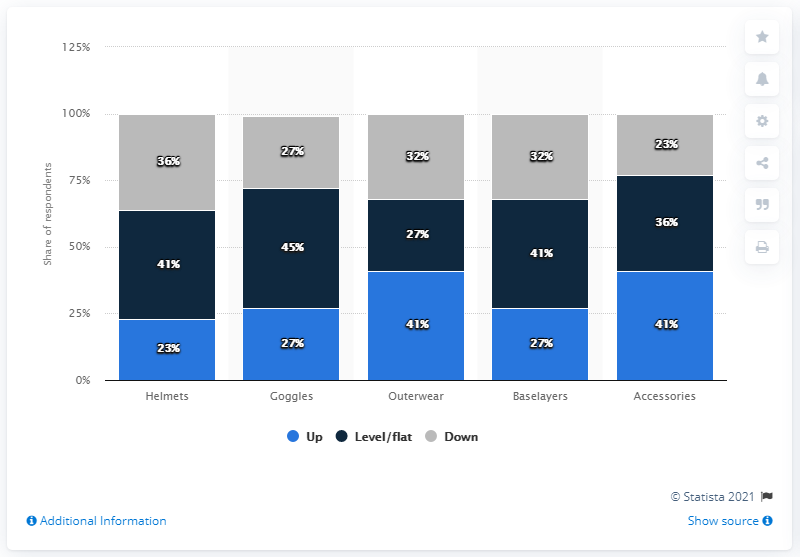

ANSWER: 36


In [15]:
from IPython.display import display

# display a random training example
print('QUESTION:', ds_train_df.iloc[0]['question'])
display(ds_train_df.iloc[0]['image'])
print('ANSWER:', ds_train_df.iloc[0]['answer'])

In [16]:
{
    "messages": 
    [
        {
            "role": "system",
            "content": "Use the image to answer the question."
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Is the cardiovascular disease more then sum of all the other disease ?"},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,<encoded_image>"}}
            ]
        }
    ]
}

{'messages': [{'role': 'system',
   'content': 'Use the image to answer the question.'},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'Is the cardiovascular disease more then sum of all the other disease ?'},
    {'type': 'image_url',
     'image_url': {'url': 'data:image/jpeg;base64,<encoded_image>'}}]}]}

In [18]:
SYSTEM_PROMPT = """
Generate an answer to the question based on the image.

# Steps

1. **Read the Question:** Carefully analyze the question to understand what information is being asked.
2. **Examine the Image:**
   - **Analyze the Whole Image:** For questions that need general reasoning (e.g., "What's the overal trend?"), consider the entire image, including title, scale, legends, colors, and overall design elements.
3. **Formulate a Reasoned Answer:**
   - For binary questions (yes/no), use evidence from the image to support your answer.
   - For open-ended questions, provide the exact text from the image or a concise phrase that best describes the requested information.

# Output Format

- Provide your answer in a concise and clear manner. Always return the final conclusion only, no additional text or reasoning.
- If the question is binary, answer with "Yes" or "No."
- For open-ended questions requesting specific details, return the exact text from the image.
- For questions about general attributes like "location" return a single word or phrase that best describes it.

# Notes
- Always prioritize accuracy and clarity in your responses.
- If the information is not present in the image, try to reason about the question using the information you can gather from the image.
- Ensure reasoning steps logically lead to the conclusions before stating your final answer.

# Examples
You will be provided with examples of questions and corresponding images, along with the reasoning and conclusion for each example. Use these examples to guide your reasoning process."""

In [20]:
import base64

def encode_image(image, quality=100):
    if image.mode != 'RGB':
        image = image.convert('RGB')  # Convert to RGB
    buffered = BytesIO()
    image.save(buffered, format="JPEG", quality=quality) 
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [21]:
FEW_SHOT_EXAMPLES = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 2:**\n\n**Question:** Is the value of Favorable 38 in 2015??"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train_df.iloc[0]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:** Yes"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 3:**\n\n**Question:** How many values are below 40 in Unfavorable graph?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train_df.iloc[1]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:** 6"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 4:**\n\n**Question:** In which year the value was 51?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train_df.iloc[2]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:** 2014"}
        ]
    }
]

In [22]:
# FEW_SHOT_EXAMPLES = []

In [23]:
from tqdm import tqdm

# constructing the training set
json_data = []

for idx, example in tqdm(ds_train_df.iterrows()):
    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    
    user_message = {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(example['image'], quality=50)}"}}
        ]
    }
    
    assistant_message = {
        "role": "assistant",
        "content": [{"type": "text", "text": example["answer"]}]
    }

    all_messages = [system_message] + FEW_SHOT_EXAMPLES + [user_message, assistant_message]
    
    json_data.append({"messages": all_messages})

0it [00:00, ?it/s]

100it [00:03, 30.48it/s]


{
    "messages": [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": "\nGenerate an answer to the question based on the image.\n\n# Steps\n\n1. **Read the Question:** Carefully analyze the question to understand what information is being asked.\n2. **Examine the Image:**\n   - **Analyze the Whole Image:** For questions that need general reasoning (e.g., \"What's the overal trend?\"), consider the entire image, including title, scale, legends, colors, and overall design elements.\n3. **Formulate a Reasoned Answer:**\n   - For binary questions (yes/no), use evidence from the image to support your answer.\n   - For open-ended questions, provide the exact text from the image or a concise phrase that best describes the requested information.\n\n# Output Format\n\n- Provide your answer in a concise and clear manner. Always return the final conclusion only, no additional text or reasoning.\n- If 
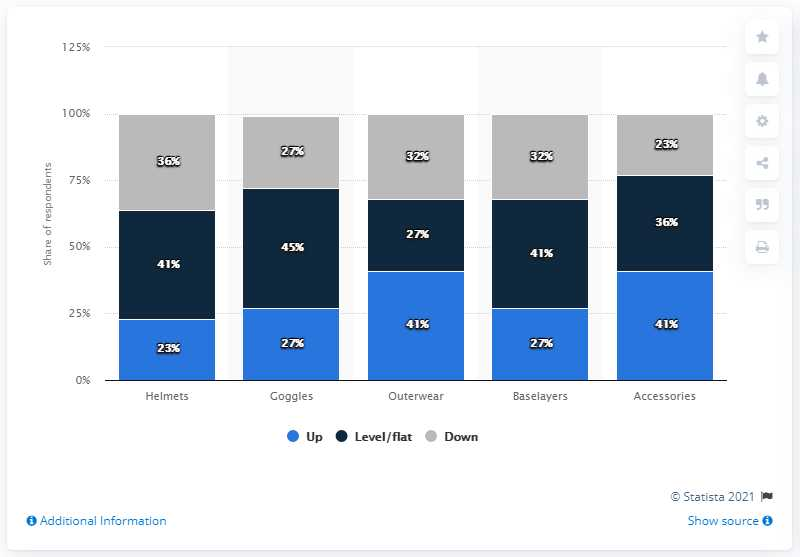
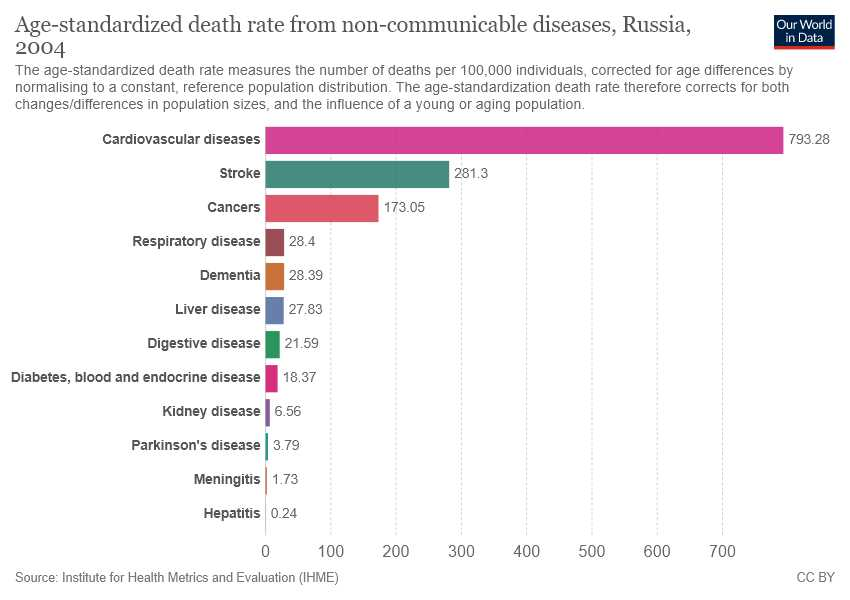
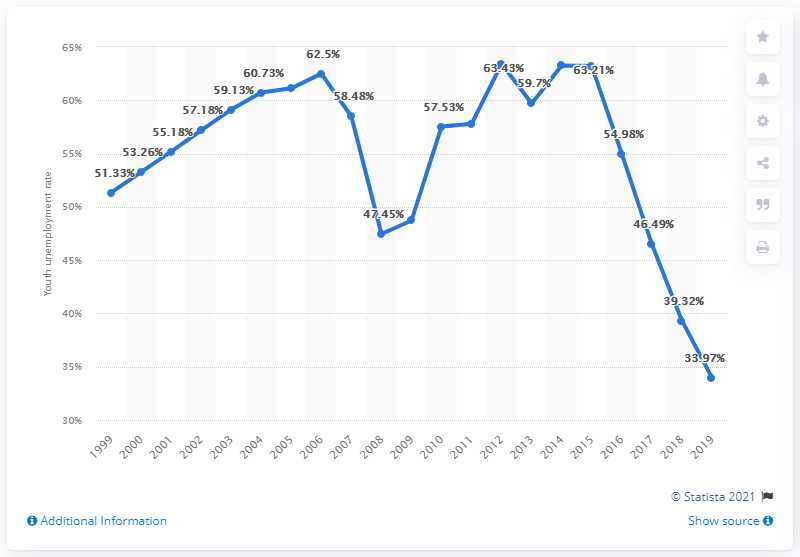
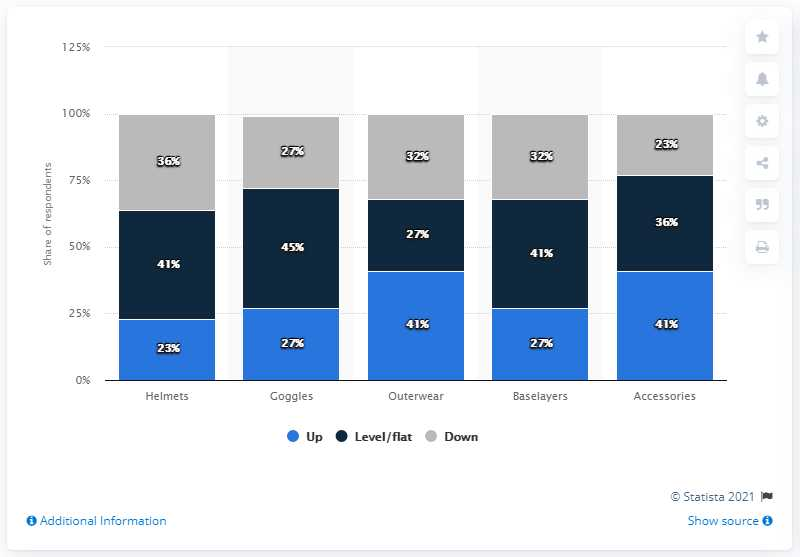

In [24]:
import json
print(json.dumps(json_data[0], indent=4))

In [25]:
# save the JSON data to a file
with open("train_dataset_chart.jsonl", "w") as f:
    for message in json_data:
        json.dump(message, f)
        f.write("\n")

In [26]:
from tqdm import tqdm

# constructing the validation set
json_data = []

for idx, example in tqdm(ds_val_df.iterrows()):
    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    
    user_message = {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(example['image'], quality=50)}"}}
        ]
    }
    
    assistant_message = {
        "role": "assistant",
        "content": [{"type": "text", "text": example["answer"]}]
    }

    all_messages = [system_message] + FEW_SHOT_EXAMPLES + [user_message, assistant_message]
    
    json_data.append({"messages": all_messages})

50it [00:01, 35.40it/s]


In [27]:
# save the JSON data to a file
with open("val_dataset_chart.jsonl", "w") as f:
    for message in json_data:
        json.dump(message, f)
        f.write("\n")

In [28]:
# constructing the test set
json_data = []

for idx, example in tqdm(ds_test_df.iterrows()):
    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    
    user_message = {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(example['image'], quality=50)}"}}
        ]
    }

    all_messages = [system_message] + FEW_SHOT_EXAMPLES + [user_message]
    
    json_data.append({"messages": all_messages})

# save the JSON data to a file
with open("test_dataset_chart.jsonl", "w") as f:
    for message in json_data:
        json.dump(message, f)
        f.write("\n")

100it [00:03, 30.08it/s]


In [29]:
# upload training file
train_file = client.files.create(
  file=open(r"C:\Users\aantonelli\source\repos\FT-GPT4o\train_dataset_chart.jsonl", "rb"),
  purpose="fine-tune"
)

# upload validation file
val_file = client.files.create(
  file=open(r"C:\Users\aantonelli\source\repos\FT-GPT4o\val_dataset_chart.jsonl", "rb"),
  purpose="fine-tune"
)

In [31]:
# create fine tuning job
file_train = train_file.id
file_val = val_file.id

response = client.fine_tuning.jobs.create(
  training_file=file_train,
  # note: validation file is optional
  validation_file=file_val,
  model="gpt-4o-2024-08-06"
)

In [ ]:
job_id = response.id
print("Job ID:", response.id)
print("Status:", response.status)
print(response)

Job ID: ftjob-33f8cb176266492b89f557b449234297
Status: pending
FineTuningJob(id='ftjob-33f8cb176266492b89f557b449234297', created_at=1732179244, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=-1, batch_size=-1, learning_rate_multiplier=1), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id=None, result_files=None, seed=215028601, status='pending', trained_tokens=None, training_file='file-16833fa2f472450dbde0f0ab96ff45f5', validation_file='file-940ef67b199f421c9db882f8c6c9e2ac', estimated_finish=1734665344, integrations=None)


In [38]:
model = response.model + '.' + response.id

In [39]:
import datetime

def check_training_status(job_id):
    """
    Check fine tuning process
    """
    response = client.fine_tuning.jobs.retrieve(job_id)

    if response:
        job_id = response.id
        print("Job ID:", job_id)
        print("Status:", response.status)
        print("Created:", datetime.datetime.utcfromtimestamp(response.created_at))
        
        if response.finished_at is not None:
            print("Finished:", datetime.datetime.utcfromtimestamp(response.finished_at))
        else:
            print("Finished: Not finished yet")
        
        print(response)
    else:
        print("No response received")

In [ ]:
check_training_status(job_id)

Job ID: ftjob-037c495945b34031a6dc9718f32ab60f
Status: pending
Created: 2024-11-20 13:49:53
Finished: Not finished yet
FineTuningJob(id='ftjob-037c495945b34031a6dc9718f32ab60f', created_at=1732110593, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=-1, batch_size=-1, learning_rate_multiplier=1), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id=None, result_files=None, seed=192106759, status='pending', trained_tokens=None, training_file='file-c7826baaf55140abb35ebdc791efc32b', validation_file='file-829cbab0a97545519944e47f472464f8', estimated_finish=1737817436, integrations=None)


In [40]:
client.fine_tuning.jobs.list()

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-33f8cb176266492b89f557b449234297', created_at=1732179244, error=None, fine_tuned_model='gpt-4o-2024-08-06.ft-33f8cb176266492b89f557b449234297', finished_at=1732188057, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=1), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id=None, result_files=['file-c39930daed5f48959596184d7ae5530b'], seed=215028601, status='succeeded', trained_tokens=12428169, training_file='file-16833fa2f472450dbde0f0ab96ff45f5', validation_file='file-940ef67b199f421c9db882f8c6c9e2ac', estimated_finish=1734665344, integrations=None), FineTuningJob(id='ftjob-3030ced04b044c3e979757e4a543802c', created_at=1732106358, error=None, fine_tuned_model='gpt-4o-2024-08-06.ft-3030ced04b044c3e979757e4a543802c', finished_at=1732124443, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=1), model='gpt-4o-2024-08-06', object='fine_tuning.job', 

# Deploy the Fine Tuned Model

In [41]:
# Retrieve fine_tuned_model name
response = client.fine_tuning.jobs.retrieve(job_id)
print(response)
fine_tuned_model = response.fine_tuned_model
print(fine_tuned_model)

FineTuningJob(id='ftjob-33f8cb176266492b89f557b449234297', created_at=1732179244, error=None, fine_tuned_model='gpt-4o-2024-08-06.ft-33f8cb176266492b89f557b449234297', finished_at=1732188057, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=1), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id=None, result_files=['file-c39930daed5f48959596184d7ae5530b'], seed=215028601, status='succeeded', trained_tokens=12428169, training_file='file-16833fa2f472450dbde0f0ab96ff45f5', validation_file='file-940ef67b199f421c9db882f8c6c9e2ac', estimated_finish=1734665344, integrations=None)
gpt-4o-2024-08-06.ft-33f8cb176266492b89f557b449234297


- token: There are multiple ways to generate an authorization token. The easiest method for initial testing is to launch the Cloud Shell from the Azure portal. Then run 'az account get-access-token'. You can use this token as your temporary authorization token for API testing. We recommend storing this in a new environment variable

- subscription: The subscription ID for the associated Azure OpenAI resource

- resource_group: The resource group name for your Azure OpenAI resource
- resource_name: The Azure OpenAI resource name

- model_deployment_name: The custom name for your new fine-tuned model deployment. This is the name that will be referenced in your code when making chat completion calls.

In [ ]:
token = os.getenv("TOKEN")
subscription = os.getenv("SUBSCRIPTION")
resource_group = os.getenv("RESOURCE_GROUP")
resource_name = os.getenv("RESOURCE_NAME")
model_deployment_name = fine_tuned_model
print(model_deployment_name)
token = "REPLACE_WITH_YOUR_TOKEN"

gpt-4o-2024-08-06.ft-33f8cb176266492b89f557b449234297


In [44]:
model_deployment_name='gpt-4o-2024-08-06.ft-33f8cb176266492b89f557b449234297'

In [46]:
import json
import requests

deploy_params = {"api-version": "2023-05-01"}
deploy_headers = {"Authorization": "Bearer {}".format(token), "Content-Type": "application/json"}

deploy_data = {
    "sku": {"name": "standard", "capacity": 1},
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": "gpt-4o-mini-2024-07-18.ft-e046f0606a1c473998d7b6b1c1ad8309",  # retrieve this value from the previous call, it will look like gpt-35-turbo-0613.ft-b044a9d3cf9c4228b5d393567f693b83
            "version": "1",
        }
    },
}
deploy_data = json.dumps(deploy_data)

request_url = f"https://management.azure.com/subscriptions/{subscription}/resourceGroups/{resource_group}/providers/Microsoft.CognitiveServices/accounts/{resource_name}/deployments/{model_deployment_name}"

print("Creating a new deployment...")

r = requests.put(request_url, params=deploy_params, headers=deploy_headers, data=deploy_data)

print(r)
print(r.reason)
#print(r.json())

Creating a new deployment...
<Response [200]>
OK


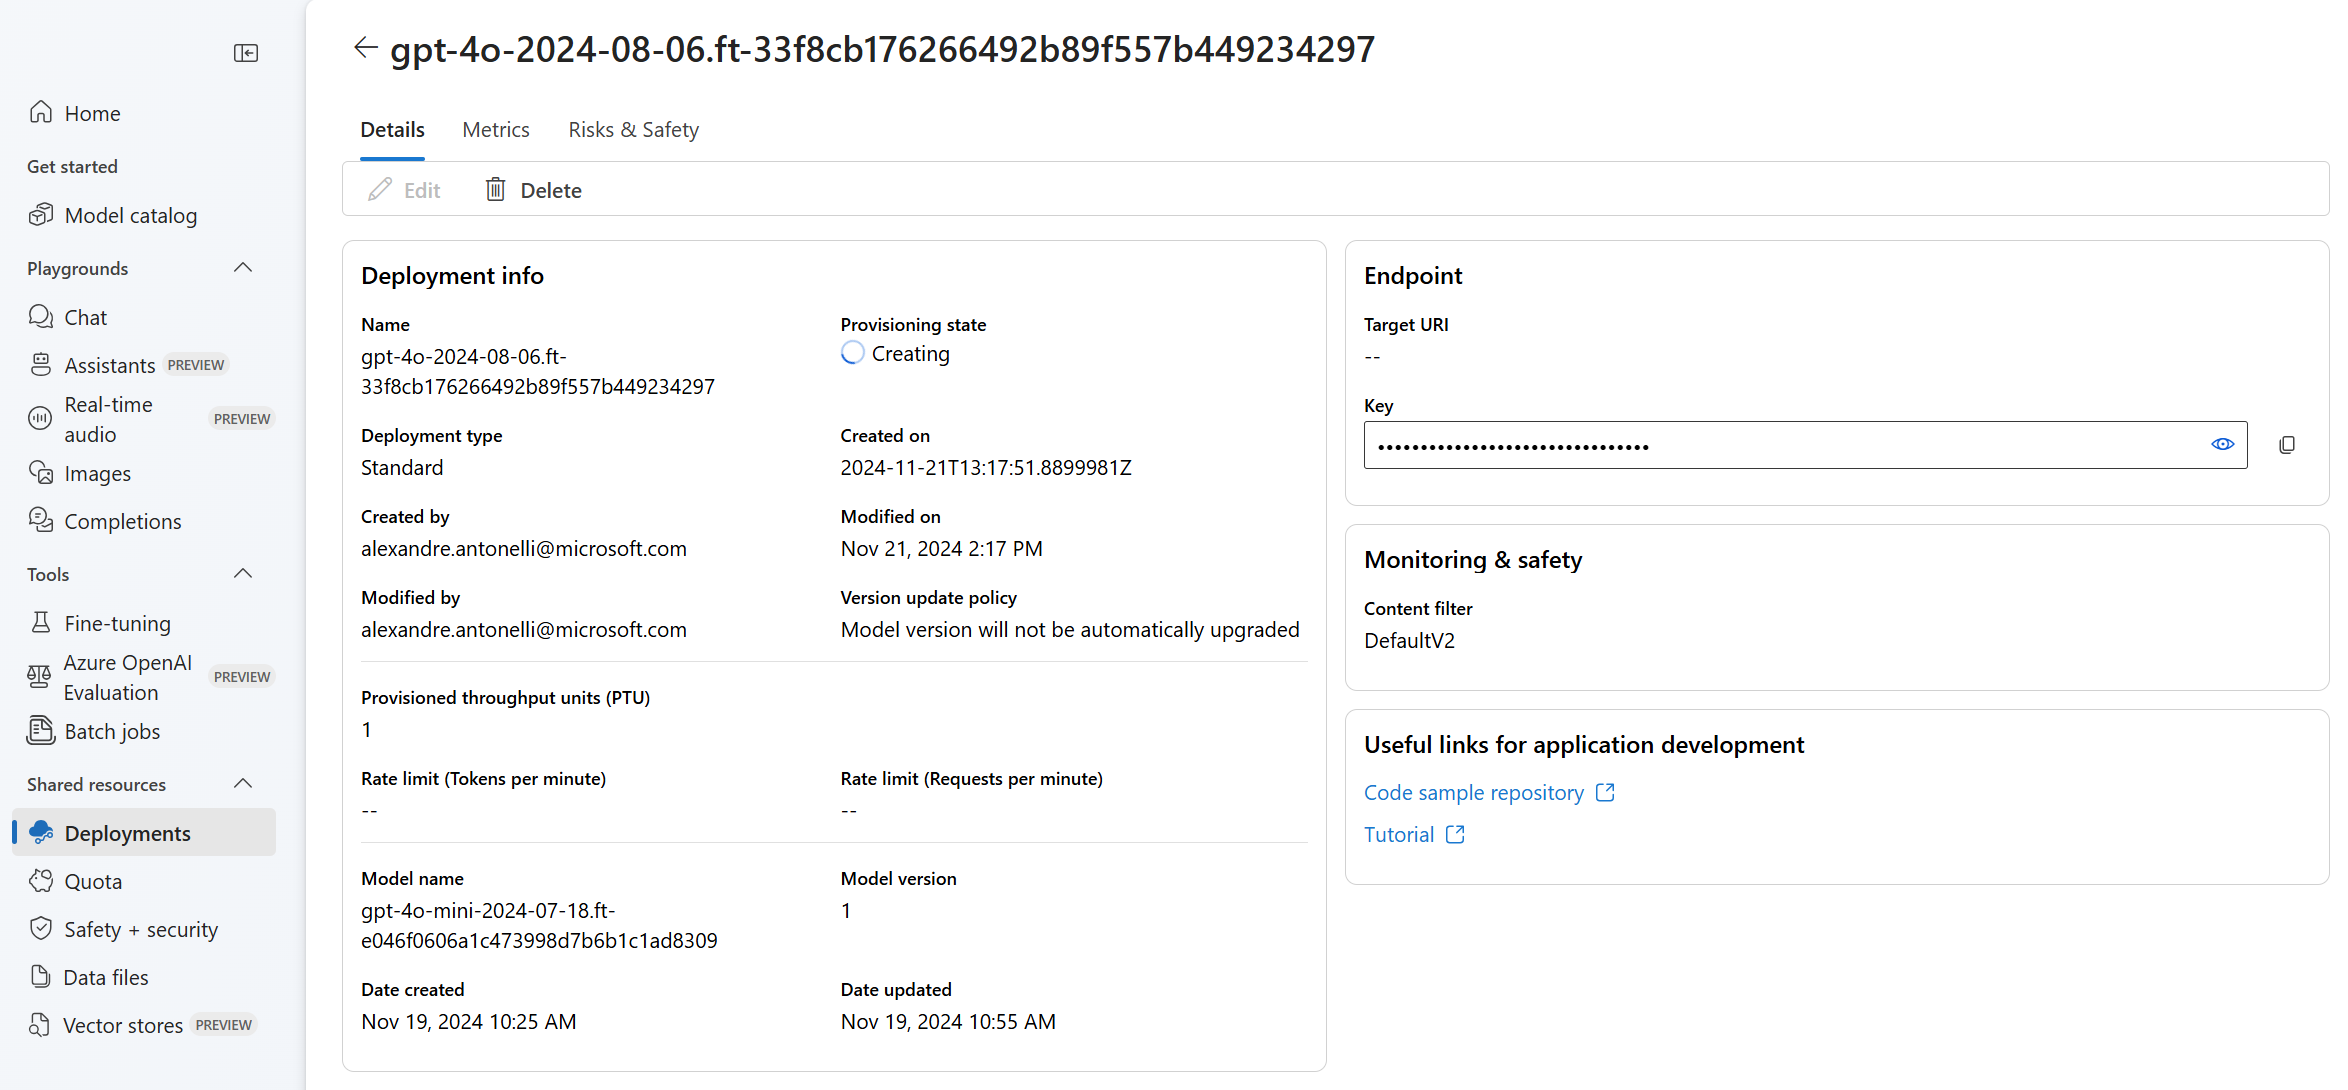

# Test the Fine Tuned Model

In [47]:
from tqdm import tqdm

In [49]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

# load the test data from JSONL file
test_data = []
with open("test_dataset_chart.jsonl", "r") as f:
    for line in f:
        test_data.append(json.loads(line))
#print(test_data[0])
def process_example(example, model):
    response = client.chat.completions.create(
        model=model,
        messages=example["messages"],
        #store=True,
        #metadata={'dataset': 'ocr-vqa-test'}
    )
    #print(response)
    predicted_answer = response.choices[0].message.content.strip()
    #print(predicted_answer)
    # regex to get the question ID
    match = re.search(r'\[(\d+)\]', example["messages"][-1]["content"][0]["text"])
    #print(match)
    if match:
        example_id = int(match.group(1))
    else:
        example_id = -1
    
    actual_answer = ds_test_df.iloc[example_id]['answer']

    return {
        "example_id": example_id,
        "predicted_answer": predicted_answer,
        "actual_answer": actual_answer
    }

# run the prompts through the finetuned model and store the results
model_ft = "gpt-4o-2024-08-06-ft-3030ced04b044c3e979757e4a543802c"
results = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_example, example, model_ft): example for example in test_data}
    for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

# save the results to a file
with open("chart-vqa-ft-results.jsonl", "w") as f:
    for result in results:
        json.dump(result, f)
        f.write("\n")

# run the prompts through the non-fine-tuned model and store the results
model = "gpt-4o"
results = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_example, example, model): example for example in test_data}
    for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

# save the results to a file
with open("chart-vqa-4o-results.jsonl", "w") as f:
    for result in results:
        json.dump(result, f)
        f.write("\n")

100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


In [ ]:
{"example_id": 0, "predicted_answer": "Independent", "actual_answer": "Independent"}
{"example_id": 1, "predicted_answer": "252", "actual_answer": "252"}
{"example_id": 5, "predicted_answer": "19871", "actual_answer": "19871"}
{"example_id": 9, "predicted_answer": "Zambia", "actual_answer": "Zambia"}
{"example_id": 2, "predicted_answer": "0.08", "actual_answer": "0.08"}
{"example_id": 4, "predicted_answer": "706", "actual_answer": "706"}
{"example_id": 3, "predicted_answer": "1.14", "actual_answer": "1.14"}
{"example_id": 11, "predicted_answer": "58", "actual_answer": "58"}

In [50]:
from ragas.metrics import (
    #answer_relevancy,
    #faithfulness,
    answer_similarity,
    #answer_correctness
)
from ragas.metrics.critique import harmfulness

# list of metrics we're going to use
metrics = [
    #faithfulness,
    #answer_relevancy,
    answer_similarity,
    #answer_correctness
]

In [ ]:
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from ragas import evaluate
from dotenv import load_dotenv
import os

load_dotenv()

judge_model_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
judge_model_api_key = os.getenv("AZURE_OPENAI_API_KEY")
judge_model_deployment = "gpt-4o" # you can use another model such as GPT-4 as a judge
embedding_model_deployment= "text-embedding-ada-002"

azure_model = AzureChatOpenAI(
    openai_api_version="2024-02-01",
    azure_endpoint=judge_model_endpoint,
    azure_deployment=judge_model_deployment,
    validate_base_url=False,
    api_key=judge_model_api_key,
)

# init the embeddings for answer_relevancy, answer_correctness and answer_similarity
azure_embeddings = AzureOpenAIEmbeddings(
    openai_api_version="2024-02-01",
    azure_endpoint=judge_model_endpoint,
    azure_deployment=embedding_model_deployment,
    api_key=judge_model_api_key,
)

In [52]:
ds_ft_results = pd.read_json("chart-vqa-ft-results.jsonl", lines=True)

In [53]:
ds_ft_results.head()

,example_id,predicted_answer,actual_answer
0,2,0.08,0.08
1,1,252,252
2,3,1.14,1.14
3,5,19871,19871
4,0,Independent,Independent


In [54]:
from datasets import Dataset

ft_df = ds_ft_results[['actual_answer',
                      'example_id',
                      'predicted_answer'
                      ]]

ft_df.rename(columns={'predicted_answer':'answer', 
                            'actual_answer':'ground_truth',
                            'example_id':'example_id'}, inplace=True)

#baseline_df['contexts'] = baseline_df['contexts'].apply(lambda x: [x] if x else [])

dataset = Dataset.from_pandas(ft_df)

In [55]:
ft_result = evaluate(
    dataset, metrics=metrics, llm=azure_model, embeddings=azure_embeddings
)

ft_result

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

{'answer_similarity': 0.9715}

In [56]:
ds_4o_results = pd.read_json("chart-vqa-4o-results.jsonl", lines=True)

In [57]:
ds_4o_results = ds_4o_results[['predicted_answer',
                      'example_id',
                      'actual_answer']]

ds_4o_results.rename(columns={'predicted_answer':'answer', 
                            'actual_answer':'ground_truth',
                            'example_id':'example_id'}, inplace=True)

#baseline_df['ground_truth'] = baseline_df['ground_truth'].apply(lambda x: [x] if x else [])
#finetuned_df['contexts'] = finetuned_df['contexts'].apply(lambda x: [x] if x else [])

dataset_4o = Dataset.from_pandas(ds_4o_results)

result_4o = evaluate(
    dataset_4o, metrics=metrics, llm=azure_model, embeddings=azure_embeddings
)

result_4o

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

{'answer_similarity': 0.8736}

In [58]:
dict_4o = dict(result_4o)
ft_dict = dict(ft_result)

ft_dict['model']=model_ft
dict_4o['model']=model

results_df = pd.DataFrame([dict_4o, ft_dict])
print(results_df)

   answer_similarity                                              model
0           0.873634                                             gpt-4o
1           0.971520  gpt-4o-2024-08-06-ft-3030ced04b044c3e979757e4a...


In [59]:
results_df.columns

Index(['answer_similarity', 'model'], dtype='object')

# Plotting the side-by-side comparison of the models

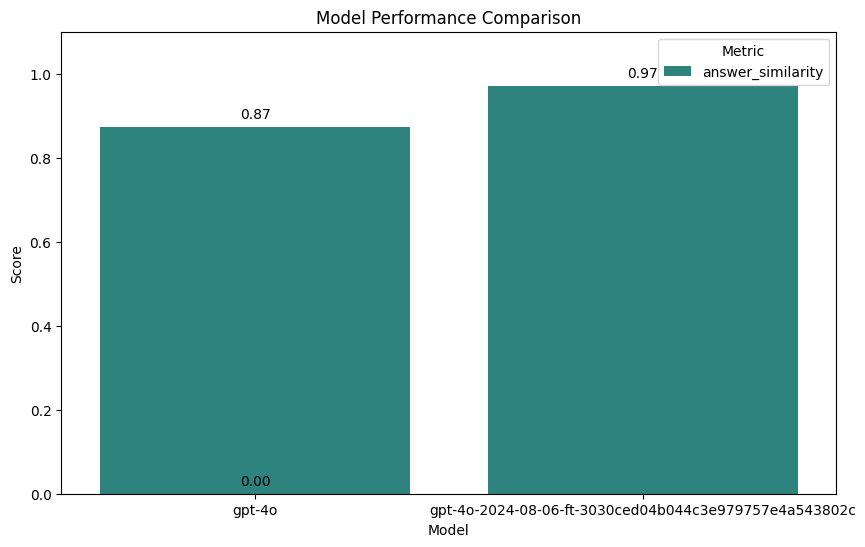

In [60]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Assuming results_df is already defined and contains the necessary data
# Reshape the dataframe
melted_df = pd.melt(results_df, id_vars=['model'], value_vars=['answer_similarity'])

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='model', y='value', hue='variable', data=melted_df, palette='viridis')

# Add value labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

# Set plot labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.1)  # Adjust the y-axis limit to ensure labels fit within the plot
plt.legend(title='Metric')
plt.show()